In [153]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import summarize, poly, ModelSpec as MS
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures


In [3]:
Boston = load_data("Boston")
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [4]:
dis = Boston["dis"]
y = Boston["nox"]
dis, y

(0      4.0900
 1      4.9671
 2      4.9671
 3      6.0622
 4      6.0622
         ...  
 501    2.4786
 502    2.2875
 503    2.1675
 504    2.3889
 505    2.5050
 Name: dis, Length: 506, dtype: float64,
 0      0.538
 1      0.469
 2      0.469
 3      0.458
 4      0.458
        ...  
 501    0.573
 502    0.573
 503    0.573
 504    0.573
 505    0.573
 Name: nox, Length: 506, dtype: float64)

### (a)

In [5]:
poly_dis = MS([poly("dis", degree=3)]).fit(Boston)
M = sm.OLS(y, poly_dis.transform(Boston)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.5547,0.003,201.021,0.0
"poly(dis, degree=3)[0]",-2.0031,0.062,-32.271,0.0
"poly(dis, degree=3)[1]",0.8563,0.062,13.796,0.0
"poly(dis, degree=3)[2]",-0.3180,0.062,-5.124,0.0


In [6]:
dis_grid = np.linspace(dis.min(), dis.max(), 100)
dis_df = pd.DataFrame({"dis": dis_grid})

In [7]:
def plot_dis_fit(dis_df, basis, title):
    X = basis.transform(Boston)
    Xnew = basis.transform(dis_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8, 8))
    ax.scatter(dis, y, facecolor="gray", alpha=0.5)

    for val, ls in zip(
        [preds.predicted_mean, bands[:, 0], bands[:, 1]], ["b", "r--", "r--"]
    ):
        ax.plot(dis_df.values, val, ls, linewidth=3)

    ax.set_title(title, fontsize=20)
    ax.set_xlabel("dis", fontsize=20)
    ax.set_ylabel("nox", fontsize=20)
    return ax

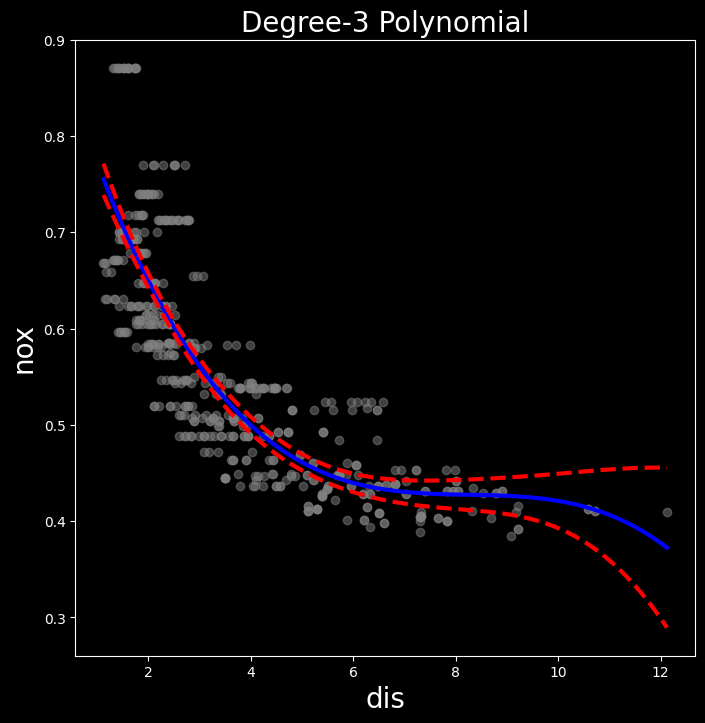

In [8]:
plot_dis_fit(dis_df, poly_dis, "Degree-3 Polynomial");

### (b)

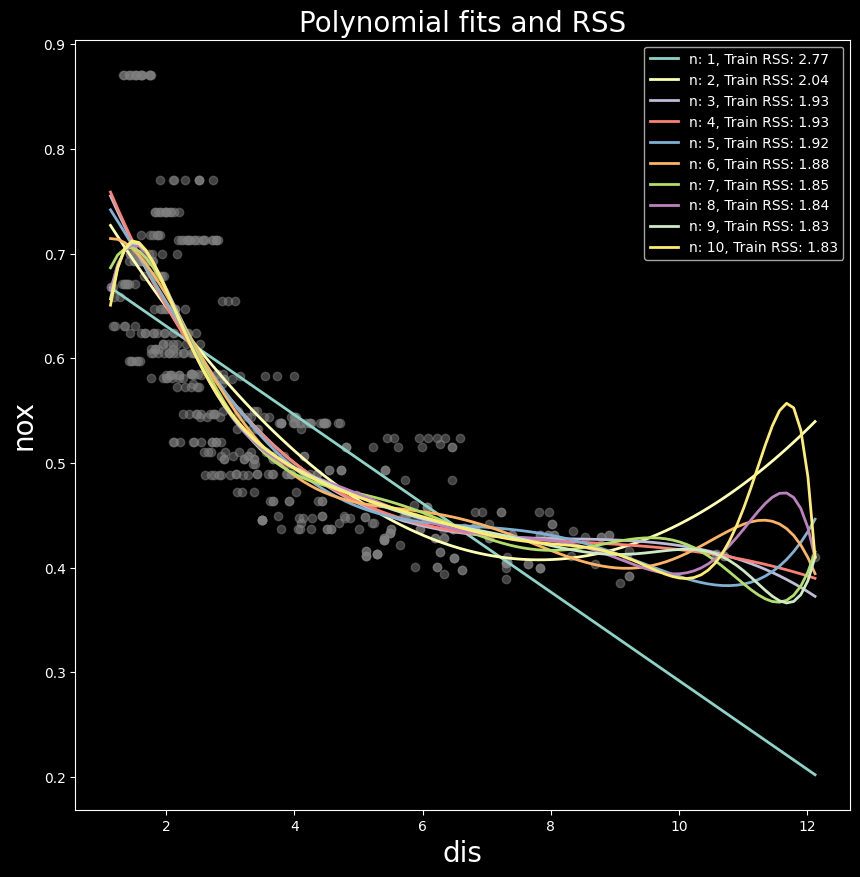

In [9]:
def plot_dis_fit_and_rss():    
    fig, ax = subplots(figsize=(10, 10))
    ax.scatter(dis, y, facecolor="gray", alpha=0.5)        
    ax.set_title("Polynomial fits and RSS", fontsize=20)
    ax.set_xlabel("dis", fontsize=20)
    ax.set_ylabel("nox", fontsize=20)

    for i in range(1, 11):
        poly_dis_ = MS([poly("dis", degree=i)]).fit(Boston)    
        X = poly_dis_.transform(Boston)
        Xnew = poly_dis_.transform(dis_df)
        M = sm.OLS(y, X).fit()
        preds = M.get_prediction(Xnew)
        ax.plot(dis_df.values, preds.predicted_mean, linewidth=2, label=f"n: {i}, Train RSS: {M.ssr:.2f}")
        ax.legend()
    return 

plot_dis_fit_and_rss()

### (c)

<Axes: xlabel='D', ylabel='MSE'>

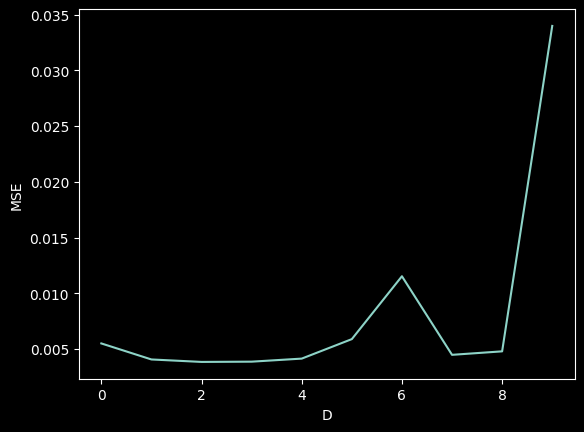

In [152]:
cross_val_errors = []

KFold = KFold(n_splits=10, shuffle=True, random_state=42)

dis_ = Boston['dis'].values.reshape(-1, 1)

for d in range(1, 11):
    poly = PolynomialFeatures(d)
    dis_poly = poly.fit_transform(dis_)
    model = LinearRegression()

    scores = cross_val_score(model, dis_poly, y, cv=KFold, scoring='neg_mean_squared_error')
    cross_val_errors.append(-scores.mean())

pd.Series(cross_val_errors).plot(xlabel='D',ylabel='MSE')

We have our best polinom model at d = 2 or 3 (lowest MSE)

### (d)

In [11]:
from ISLP.models import bs

bs_dis = MS([bs('dis', internal_knots=[])])
Xbs = bs_dis.fit_transform(Boston)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.7552,0.008,91.168,0.0
"bs(dis, internal_knots=[])[0]",-0.4983,0.033,-15.312,0.0
"bs(dis, internal_knots=[])[1]",-0.2335,0.037,-6.312,0.0
"bs(dis, internal_knots=[])[2]",-0.3827,0.045,-8.419,0.0


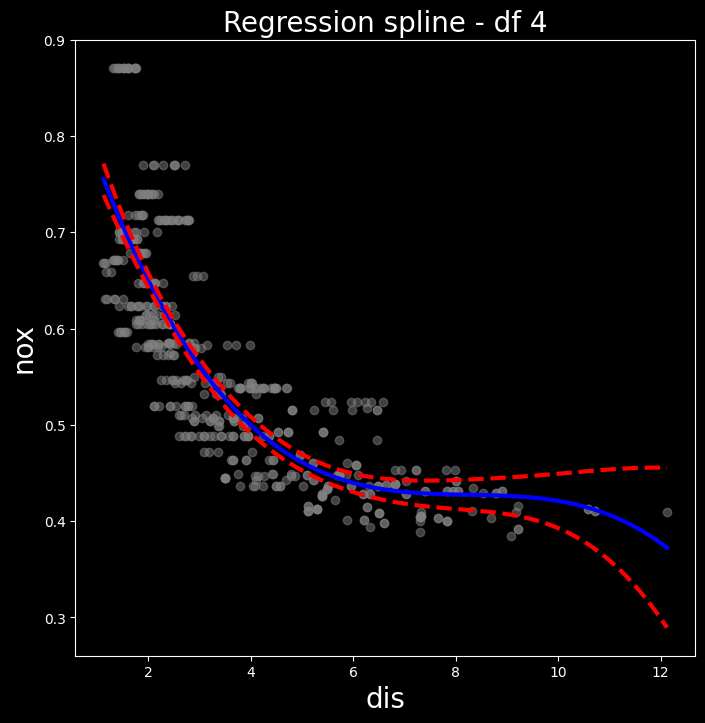

In [12]:
plot_dis_fit(dis_df, bs_dis, "Regression spline - df 4");

**four degrees of freedom** with cubic polinom means "there is no division into knots". K+4 = 0 => k = 0

### (e)

<Axes: title={'center': 'Regression spline'}, xlabel='dis', ylabel='nox'>

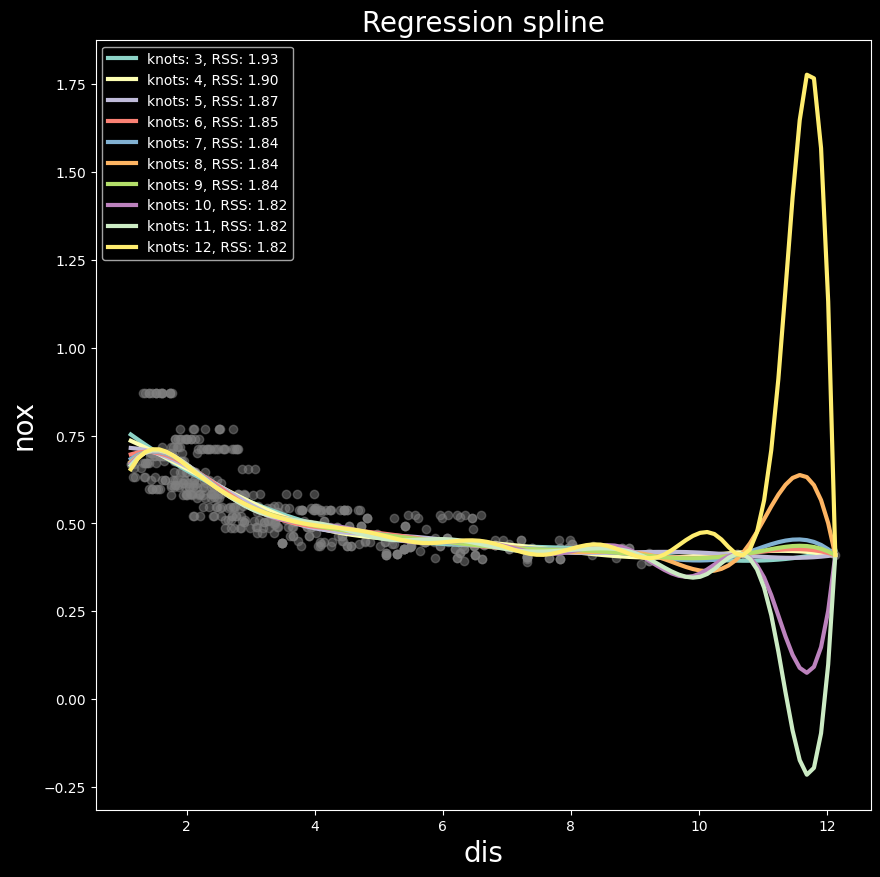

In [39]:
def e():
    min = dis.min()
    max = dis.max()

    fig, ax = subplots(figsize=(10, 10))
    ax.scatter(dis, y, facecolor="gray", alpha=0.5)

    for k in range(3, 13):
        knots = np.linspace(min, max, k+1)[1:-1]
        basis = MS([bs('dis', internal_knots=knots)])
        basis.fit_transform(Boston)


        X = basis.transform(Boston)
        Xnew = basis.transform(dis_df)
        M = sm.OLS(y, X).fit()
        preds = M.get_prediction(Xnew)        
        
        ax.plot(dis_df.values, preds.predicted_mean, linewidth=3, label=f'knots: {k}, RSS: {M.ssr:.2f}')                    

    ax.set_title('Regression spline', fontsize=20)
    ax.set_xlabel("dis", fontsize=20)
    ax.set_ylabel("nox", fontsize=20)
    ax.legend()
    return ax
e()

RSS decreases up to K=10 (in the tested range). Selected range is small for the sake of plot clarity.

### (f)

In [170]:
from pygam import LinearGAM, s

cross_val_errors_spline = []
df_r = []

for df in range(4, 11):
    #spline_model = bs(dis, Boston['nox'], df=df)
    gam = LinearGAM(s(0, n_splines=df), y).fit(dis_.reshape(-1, 1), y)
   
    scores = cross_val_score(gam, dis_.reshape(-1, 1), y, cv=KFold, scoring='neg_mean_squared_error')
    cross_val_errors_spline.append(-scores.mean()) 
    df_r.append(df)

# # Plot the cross-validation errors
# plt.plot(range(2, 11), cross_val_errors_spline, marker='o')
# plt.xlabel('Degrees of Freedom')
# plt.ylabel('Cross-Validated MSE')
# plt.show()

#print(cross_val_errors_spline)

pd.Series(cross_val_errors_spline, index=df_r).plot(xlabel='df', ylabel='Test score')


TypeError: max_iter must be int >=1, but found max_iter = 0      0.538
1      0.469
2      0.469
3      0.458
4      0.458
       ...  
501    0.573
502    0.573
503    0.573
504    0.573
505    0.573
Name: nox, Length: 506, dtype: float64

[0.005508209161236685,
 0.004070163427717705,
 0.003849309730426046,
 0.003872484517947946,
 0.004146470741660424,
 0.005894962901043557,
 0.011533267722600014,
 0.004485726159870683,
 0.004797553192420241,
 0.033985983794162844]

In [141]:
# slice 3-rd column from Boston
dis = Boston['dis'].values.reshape(-1, 1)
dis

array([[ 4.09  ],
       [ 4.9671],
       [ 4.9671],
       [ 6.0622],
       [ 6.0622],
       [ 6.0622],
       [ 5.5605],
       [ 5.9505],
       [ 6.0821],
       [ 6.5921],
       [ 6.3467],
       [ 6.2267],
       [ 5.4509],
       [ 4.7075],
       [ 4.4619],
       [ 4.4986],
       [ 4.4986],
       [ 4.2579],
       [ 3.7965],
       [ 3.7965],
       [ 3.7979],
       [ 4.0123],
       [ 3.9769],
       [ 4.0952],
       [ 4.3996],
       [ 4.4546],
       [ 4.682 ],
       [ 4.4534],
       [ 4.4547],
       [ 4.239 ],
       [ 4.233 ],
       [ 4.175 ],
       [ 3.99  ],
       [ 3.7872],
       [ 3.7598],
       [ 3.3603],
       [ 3.3779],
       [ 3.9342],
       [ 3.8473],
       [ 5.4011],
       [ 5.4011],
       [ 5.7209],
       [ 5.7209],
       [ 5.7209],
       [ 5.7209],
       [ 5.1004],
       [ 5.1004],
       [ 5.6894],
       [ 5.87  ],
       [ 6.0877],
       [ 6.8147],
       [ 6.8147],
       [ 6.8147],
       [ 6.8147],
       [ 7.3197],
       [ 8